# Project milestone 2

## 1 - Import

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
import json

## 2 - Build the initial dataset and split it into 3 regions of interest

In [44]:
# Load initial dataset
df_movies = pd.read_csv('movie.metadata.tsv', sep='\t',header=None)
df_movies.columns = ['Wikipedia movie ID','Freebase movie ID','Movie name','Movie release date','Movie box office revenue','Movie runtime',
                    'Movie languages (Freebase ID:name tuples)','Movie countries (Freebase ID:name tuples)','Movie genres (Freebase ID:name tuples)']

df_char = pd.read_csv('./character.metadata.tsv', sep='\t',header=None)
df_char.columns = ['Wikipedia movie ID','Freebase movie ID','Movie release date','Character name','Actor date of birth','Actor gender','Actor height (in meters)','Actor ethnicity (Freebase ID)','Actor name','Actor age at movie release','Freebase character/actor map ID','Freebase character ID','Freebase actor ID']

#Merge both to work with only one
world = pd.merge(df_movies,df_char,on=['Freebase movie ID','Wikipedia movie ID','Movie release date'])


#Clean the dataset
init_len = world.shape[0]
world.dropna(subset = ['Actor gender', 'Movie release date'],inplace=True)
world.query('`Actor age at movie release` > 0', inplace=True)
world.query('`Movie release date` >= "1900"', inplace=True)
world['Movie release date'] = pd.to_datetime(world['Movie release date']).dt.year
perc = world.shape[0]/init_len *100
print("%.2f" % perc, '% of entries are exploitable')

world['Movie countries (Freebase ID:name tuples)'] = world['Movie countries (Freebase ID:name tuples)'].apply(lambda x: json.loads(x)) # Converts to dictionnary
world['Movie countries (Freebase ID:name tuples)'] = world['Movie countries (Freebase ID:name tuples)'].apply(lambda x: list(x.values()))
world['Movie countries (Freebase ID:name tuples)'] = world['Movie countries (Freebase ID:name tuples)'].astype('str')
world['Movie languages (Freebase ID:name tuples)'] = world['Movie languages (Freebase ID:name tuples)'].apply(lambda x: json.loads(x)) # Converts to dictionnary
world['Movie languages (Freebase ID:name tuples)'] = world['Movie languages (Freebase ID:name tuples)'].apply(lambda x: list(x.values()))
world['Movie languages (Freebase ID:name tuples)'] = world['Movie languages (Freebase ID:name tuples)'].astype('str')
world['Movie genres (Freebase ID:name tuples)'] = world['Movie genres (Freebase ID:name tuples)'].apply(lambda x: json.loads(x)) # Converts to dictionnary
world['Movie genres (Freebase ID:name tuples)'] = world['Movie genres (Freebase ID:name tuples)'].apply(lambda x: list(x.values()))
world['Movie genres (Freebase ID:name tuples)'] = world['Movie genres (Freebase ID:name tuples)'].astype('str')


#Split it into three regions
usa_df = world[world['Movie countries (Freebase ID:name tuples)'].str.contains('United State')]
print('usa entries :',usa_df.shape[0])
india_df = world[world['Movie countries (Freebase ID:name tuples)'].str.contains('India')]
print('india entries :',india_df.shape[0])
europe = ['France','Italy','German','Spain','Luxembourg','Netherlands']
europe_df = world[world['Movie countries (Freebase ID:name tuples)'].str.contains('|'.join(europe),case=False)]
print('europe entries :',europe_df.shape[0])

64.43 % of entries are exploitable
usa entries : 166681
india entries : 31968
europe entries : 37839


In [50]:
def bootstrap_CI(data, nbr_draws):
    means = np.zeros(nbr_draws)
    data = np.array(data)

    for n in range(nbr_draws):
        indices = np.random.randint(0, len(data), len(data))
        data_tmp = data[indices] 
        means[n] = np.nanmean(data_tmp)

    return [np.nanpercentile(means, 2.5),np.nanpercentile(means, 97.5)]

## Exploration 

### Evolution of the actor/actress age

In [56]:
#Usa
usa_men = usa_df.query('`Actor gender` == "M"')
usa_women = usa_df.query('`Actor gender` == "F"')
stats_by_year_usa_men = usa_men.groupby(usa_men['Movie release date']).apply(lambda x: pd.Series({
        'average_age': x['Actor age at movie release'].mean(),
        'lower_err_age': bootstrap_CI(x['Actor age at movie release'], 1000)[0],
        'upper_err_age': bootstrap_CI(x['Actor age at movie release'], 1000)[1]
    }))
stats_by_year_usa_women = usa_women.groupby(usa_women['Movie release date']).apply(lambda x: pd.Series({
        'average_age': x['Actor age at movie release'].mean(),
        'lower_err_age': bootstrap_CI(x['Actor age at movie release'], 1000)[0],
        'upper_err_age': bootstrap_CI(x['Actor age at movie release'], 1000)[1]
    }))

#India
india_men = india_df.query('`Actor gender` == "M"')
india_women = india_df.query('`Actor gender` == "F"')
stats_by_year_india_men = india_men.groupby(india_men['Movie release date']).apply(lambda x: pd.Series({
        'average_age': x['Actor age at movie release'].mean(),
        'lower_err_age': bootstrap_CI(x['Actor age at movie release'], 1000)[0],
        'upper_err_age': bootstrap_CI(x['Actor age at movie release'], 1000)[1]
    }))
stats_by_year_india_women = india_women.groupby(india_women['Movie release date']).apply(lambda x: pd.Series({
        'average_age': x['Actor age at movie release'].mean(),
        'lower_err_age': bootstrap_CI(x['Actor age at movie release'], 1000)[0],
        'upper_err_age': bootstrap_CI(x['Actor age at movie release'], 1000)[1]
    }))

#Europe
europe_men = europe_df.query('`Actor gender` == "M"')
europe_women = europe_df.query('`Actor gender` == "F"')
stats_by_year_europe_men = europe_men.groupby(europe_men['Movie release date']).apply(lambda x: pd.Series({
        'average_age': x['Actor age at movie release'].mean(),
        'lower_err_age': bootstrap_CI(x['Actor age at movie release'], 1000)[0],
        'upper_err_age': bootstrap_CI(x['Actor age at movie release'], 1000)[1]
    }))
stats_by_year_europe_women = europe_women.groupby(europe_women['Movie release date']).apply(lambda x: pd.Series({
        'average_age': x['Actor age at movie release'].mean(),
        'lower_err_age': bootstrap_CI(x['Actor age at movie release'], 1000)[0],
        'upper_err_age': bootstrap_CI(x['Actor age at movie release'], 1000)[1]
    }))

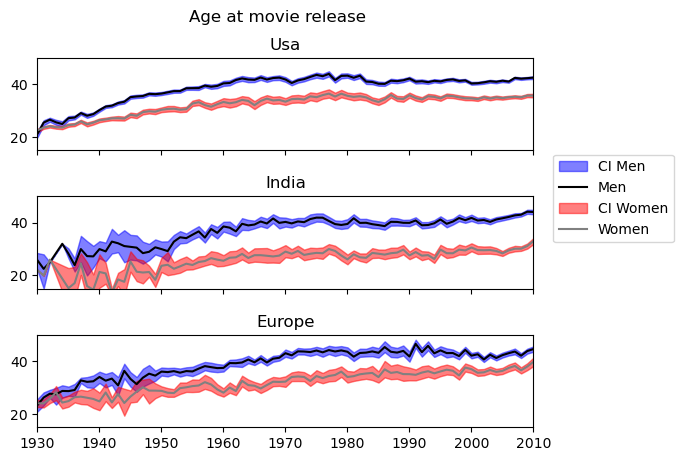

In [93]:
fig, (ax1, ax2, ax3) = plt.subplots(3, sharex=True, sharey=True)
fig.suptitle('Age at movie release')
fig.subplots_adjust(hspace=.5)
ax1.set_xlim([1930,2010])
ax1.set_ylim([15,50])



#USA :
ax1.set_title('Usa')
ax1.fill_between(stats_by_year_usa_men.index, stats_by_year_usa_men.lower_err_age,
                 stats_by_year_usa_men.upper_err_age, alpha = 0.5, color = 'blue')
ax1.plot(stats_by_year_usa_men.average_age, color = 'black')

ax1.fill_between(stats_by_year_usa_women.index, stats_by_year_usa_women.lower_err_age,
                 stats_by_year_usa_women.upper_err_age, alpha = 0.5, color = 'red')
ax1.plot(stats_by_year_usa_women.average_age, color = 'grey')



#INDIA :
ax2.set_title('India')
ax2.fill_between(stats_by_year_india_men.index, stats_by_year_india_men.lower_err_age,
                 stats_by_year_india_men.upper_err_age, alpha = 0.5, color = 'blue')
ax2.plot(stats_by_year_india_men.average_age, color = 'black')

ax2.fill_between(stats_by_year_india_women.index, stats_by_year_india_women.lower_err_age,
                 stats_by_year_india_women.upper_err_age, alpha = 0.5, color = 'red')
ax2.plot(stats_by_year_india_women.average_age, color = 'grey')


#EUROPE :
ax3.set_title('Europe')
ax3.fill_between(stats_by_year_europe_men.index, stats_by_year_europe_men.lower_err_age,
               stats_by_year_europe_men.upper_err_age, alpha = 0.5, color = 'blue')
ax3.plot(stats_by_year_europe_men.average_age, color = 'black')

ax3.fill_between(stats_by_year_europe_women.index, stats_by_year_europe_women.lower_err_age,
                 stats_by_year_europe_women.upper_err_age, alpha = 0.5, color = 'red')
ax3.plot(stats_by_year_europe_women.average_age, color = 'grey')
plt.legend(['CI Men','Men', 'CI Women', 'Women'],loc=(1.04, 2))

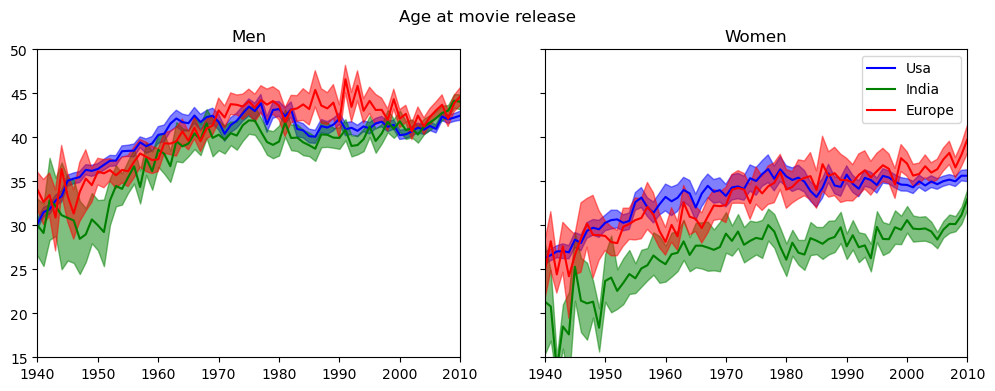

In [119]:
# or all in the same plot :   left = men  and right =Women
fig, (ax1, ax2) = plt.subplots(1,2, sharey=True, sharex=True, figsize=(12, 4))
fig.suptitle('Age at movie release')
fig.subplots_adjust(hspace=.1)
ax1.set_xlim([1930,2010])
ax1.set_ylim([15,50])
ax1.set_title('Men')
ax2.set_title('Women')

#USA :

ax1.fill_between(stats_by_year_usa_men.index, stats_by_year_usa_men.lower_err_age,
                 stats_by_year_usa_men.upper_err_age, alpha = 0.5, color = 'blue')
ax1.plot(stats_by_year_usa_men.average_age, color = 'blue')

ax2.fill_between(stats_by_year_usa_women.index, stats_by_year_usa_women.lower_err_age,
                 stats_by_year_usa_women.upper_err_age, alpha = 0.5, color = 'blue')
ax2.plot(stats_by_year_usa_women.average_age, color = 'blue', label='Usa')



#INDIA :

ax1.fill_between(stats_by_year_india_men.index, stats_by_year_india_men.lower_err_age,
                 stats_by_year_india_men.upper_err_age, alpha = 0.5, color = 'green')
ax1.plot(stats_by_year_india_men.average_age, color = 'green', label='India')

ax2.fill_between(stats_by_year_india_women.index, stats_by_year_india_women.lower_err_age,
                 stats_by_year_india_women.upper_err_age, alpha = 0.5, color = 'green')
ax2.plot(stats_by_year_india_women.average_age, color = 'green', label='India')


#EUROPE :

ax1.fill_between(stats_by_year_europe_men.index, stats_by_year_europe_men.lower_err_age,
               stats_by_year_europe_men.upper_err_age, alpha = 0.5, color = 'red')
ax1.plot(stats_by_year_europe_men.average_age, color = 'red')

ax2.fill_between(stats_by_year_europe_women.index, stats_by_year_europe_women.lower_err_age,
                 stats_by_year_europe_women.upper_err_age, alpha = 0.5, color = 'red')
ax2.plot(stats_by_year_europe_women.average_age, color = 'red', label='Europe')

plt.xlim([1940,2010])
plt.ylim([15,50])

plt.legend()